In [592]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.integrate import solve_ivp
plt.style.use('seaborn-darkgrid')
import datetime
from copy import deepcopy
from scipy.stats import norm
from scipy.optimize import differential_evolution
import pdb
from IPython.core.display import HTML
from math import ceil
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import chain
from scipy.signal import savgol_filter
from scipy.special import expit

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [70]:
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])
        
    def train_data(self, threshold):
        self.fetch()
        index = np.where(self.cases_time_series["totaldeceased"] > threshold)[0][0]
        startdate = self.cases_time_series["date"][index]
        return self.cases_time_series["totaldeceased"][index:], startdate

In [71]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased' : [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

The SEIR model is defined as 

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dE}{dt} = \frac{RIS}{T_{inf}}  - \frac{E}{T_{inc}} 
$$

$$
\frac{dI}{dt} = \frac{E}{T_{inc}}  - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{I}{T_{inf}} 
$$

$S, E, I, X$ are respectively the number of people that are susceptible, exposed, infected and removed. $R$ is the time-dependent value of the basic reproduction number. $T_{inf}$, $T_{inc}$ are the average infection and incubation periods respectively. $R$ can be related to social distancing data as follows

$$
R =  \lambda(\Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w})
$$

here $\lambda$ is a tunable parameter and other values are

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces


In [388]:
# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (E / T_inc)

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (E / T_inc) - (I / T_inf)

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (I / T_inf)

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = S + dS_dt(S, I, reproduction, T_inf)
    E_out = E + dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = I + dI_dt(I, E, T_inc, T_inf)
    R_out = R + dR_dt(I, T_inf)

    return [S_out, E_out, I_out, R_out]

def SIR_model(t, y, R_t, case_mortality, T_inf, T_inc, *R_args):
    if callable(R_t):
        reproduction = R_t(t, *R_args)
    else:
        reproduction = R_t
    
    S, I, R = y
    S_out = S + dS_dt(S, I, reproduction, T_inf)
    I_out = I + dI_dt(I, 0, T_inc, T_inf) - dS_dt(S, I, reproduction, T_inf)
    R_out = R + dR_dt(I, T_inf) * case_mortality

    return [S_out, I_out, R_out]

## Check Equations
R_0 is taken as a constant; check if the equations are correct <br/>
Parameters taken from https://gabgoh.github.io/COVID/index.html

## Fitting with real data - NYC


In [36]:
# Fetch data from NYC
! rm time_series_covid19_deaths_US.csv*
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv

raw_data_us = pd.read_csv("time_series_covid19_deaths_US.csv")
start_date = datetime.date(2020, 1, 22)
date_format = "%-m/%-d/%y"

# Extract NYC time_series data
deaths_time_series_nyc = []
date = deepcopy(start_date)
df_nyc = raw_data_us[raw_data_us['Combined_Key'].str.contains("New York City")]
df_nyc_cols = df_nyc.columns.values

while date.strftime(date_format) in df_nyc_cols:
    deaths_time_series_nyc.extend(df_nyc[date.strftime(date_format)].values)
    date = date + datetime.timedelta(days=1)

deaths_time_series_nyc = np.array(deaths_time_series_nyc)
deaths_time_series_nyc[1:] = np.diff(deaths_time_series_nyc)

2020-05-27 02:42:01 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv [1177355/1177355] -> "time_series_covid19_deaths_US.csv" [1]


In [76]:
# start_date_sd = datetime.date(2020, 2, 15)
# df_sd = pd.read_csv("Global_Mobility_Report.csv")
# df_sd = df_sd[df_sd['country_region_code'] == 'US']

# counties = ["New York County", "Kings County", "Bronx County", "Queens County"]
# sd_data = 
# df_sd[df_sd['sub_region_2'] == "Kings County"]

In [126]:
def smoothen(X, std):
    result = np.zeros_like(X)
    
    for i, _ in enumerate(X):
        norm_factor = 0
        for j, _X in enumerate(X):
            val = norm.pdf(j, loc=i, scale=std)
            result[i] += _X * val
            norm_factor += val
        result[i] /= norm_factor
    
    return result

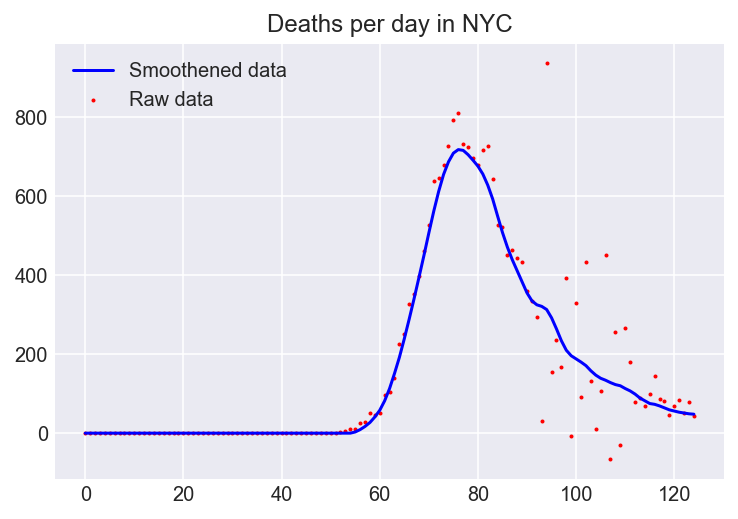

In [555]:
# Data visualization
smooth_data_nyc = smoothen(smoothen(smoothen(smoothen(smoothen(deaths_time_series_nyc, 1), 1), 1), 1), 1)

plt.scatter(np.arange(smooth_data_nyc.shape[0]), deaths_time_series_nyc, label="Raw data", s=1, c='red')
plt.plot(smooth_data_nyc, label="Smoothened data", c='blue')
plt.legend()
plt.title("Deaths per day in NYC")
plt.show()

In [304]:
def rmse_loss(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

In [305]:
def simple_seir(t_max, pop, I_init, R):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    E = 0
    I = I_init
    X = 0

    for t in range(1, t_max + 1):
        S, E, I, X = SEIR_model(t, [S, E, I, X], R, T_inf, T_inc)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

In [452]:
def simple_sir(t_max, pop, I_init, R, case_mortality, T_inf, offset):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    I = I_init
    X = 0

    for t in range(1, t_max + 1):
        S, I, X = SIR_model(t, [S, I, X], R, case_mortality, T_inf, 1)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

In [453]:
def run_model(*params, return_preds=False):
    model, loss_fun, daily_deaths = params[-3:]
    
    offset = int(params[0][0])
    t_max = daily_deaths[offset:].shape[0] - 1
    preds = model(t_max, *params[0])

    loss = loss_fun(preds, daily_deaths[offset:])
    
    if not return_preds:
        return loss
    else:
        return loss, preds

In [625]:
def fit_model(*model_args, bounds=None, verbose=True):

    def print_progress(xk, convergence=0):                
        if verbose:
            np.set_printoptions(
                formatter={
                    'float': lambda x: "{:.1e}".format(x)
                }
            )
            
            if xk.shape[0] > 6:
                print("x0: {} conv: {:.3e}".format(xk[:6], convergence), end="\r")
            else:
                print("x0: {} conv: {:.3e}".format(xk, convergence), end="\r")


    result = differential_evolution(run_model,
                                    args=model_args,
                                    bounds=bounds,
                                    callback=print_progress)

    print(result.message)
    return result.x

In [486]:
def get_model_stats(model, loss_fun, data, breakpoints, plot_title, bounds, param_cols, huge=False):
    df = pd.DataFrame()
    df['Breakpoint'] = []
    df['Loss']       = []
    
    
    for col in param_cols:
        df[col] = []
    
    time_values = np.arange(data.shape[0])
    
    if huge:
        col_num = 2
        row_num = ceil(len(breakpoints) / col_num)
        fig, axs = plt.subplots(row_num, col_num, figsize=(25, 10 * row_num), sharex=True, sharey=True)
    else:
        col_num = 3
        row_num = ceil(len(breakpoints) / col_num)
        fig, axs = plt.subplots(row_num, col_num, figsize=(15, 4 * row_num), sharex=True, sharey=True)
    
    for b, ax in zip(breakpoints, axs.flat):
        params = fit_model(model, loss_fun, data[:b], bounds=bounds, verbose=True)
        offset = int(params[0])
        
        loss, preds = run_model(params, model, loss_fun, data, return_preds=True)
        
        ax.plot(time_values[offset:], preds, label="Projected deaths")
        ax.scatter(time_values[:b], data[:b], s=2, c='green', label="Used points")
        ax.scatter(time_values[b:], data[b:], s=2, c='red', label="Unused points")
        ax.axvspan(b, time_values[-1], facecolor='r', alpha=0.2)
        ax.set_title("NYC | {} days".format(b))
        ax.set_xlabel("Days")
        ax.set_ylabel("Deaths")
        ax.legend()
        

        df_dict = {
            "Breakpoint": [b],
            "Loss"      : [loss],
        }

        for i, col in enumerate(param_cols):
            df_dict[col] = [params[i]]

        df = df.append(pd.DataFrame(df_dict))
    
    fig.suptitle(plot_title, fontsize=15)
    fig.tight_layout(pad=2.0)
    return df

<h2>Fitting a SIR model without social distancing</h2>

Simple SIR model to test the code and get baseline statistics

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dI}{dt} = \frac{RIS}{T_{inf}}   - \frac{I}{T_{inf}} 
$$

$$
\frac{dX}{dt} = \frac{\lambda I}{T_{inf}} 
$$

Here, $R$ is the reproduction number, $\lambda$ is the fraction of people who die (it is assumed that people die and recover at the same rate). The tunable parameters are 

* $R$ - (fixed) reproduction number 
* $\lambda$ - the fraction of recovered people who die
* $\texttt{offset}$ - from where to start the prediction, 
* $I_0$ - the initial number of infected people
* $T_{inf}$ - the average time for which a person remains infectious (regardless of whether they die or not)

We can see a problem here -- the SIR model is not able to predict a long tail for the deaths. This is because in the absence of lockdown measures, the disease spreads through the population rapidly, infecting everyone in a short time. Lockdown measures serve to clamp down on the transmissibility of the disease.

In [342]:
# Get interactive plot
def plot_sir(offset, pop, I_init, R, mort, T_inf, daily_deaths):
    time_values = np.arange(daily_deaths.shape[0])
    t_max = time_values[offset:].shape[0] - 1
    
    preds = simple_sir(t_max, pop, I_init, R, mort, T_inf)
    
    
    plt.plot(time_values[offset:], preds, label="Projected deaths")
    plt.plot(time_values, daily_deaths, '.', label="Actual deaths")
    plt.title("Interactive SIR plot")
    plt.show()

interact(plot_sir, offset=10, pop=82206, I_init=0.000197, R=3, mort=0.105688, T_inf=6, daily_deaths=fixed(smooth_data_nyc))

interactive(children=(IntSlider(value=10, description='offset', max=30, min=-10), IntSlider(value=82206, descr…

<function __main__.plot_sir(offset, pop, I_init, R, mort, T_inf, daily_deaths)>

Optimization terminated successfully.6.8e-03 6.0e+00] conv: 1.060e+00
Optimization terminated successfully.5.1e-03 6.2e+00] conv: 1.390e+00
Optimization terminated successfully.1.1e-02 6.9e+00] conv: 1.038e+00
Optimization terminated successfully.2.0e-02 7.5e+00] conv: 1.036e+00
Optimization terminated successfully.5.2e-03 7.9e+00] conv: 1.060e+00
Optimization terminated successfully.5.4e-03 8.0e+00] conv: 1.028e+00


,Breakpoint,Loss,offset,pop,I_init,R,mort,T_inf
0,70.0,71.503368,15.644001,2.718505e+06,8.699973e-07,2.599896,0.006835,6.000144
0,80.0,77.911594,29.681924,3.427042e+06,3.267401e-05,2.599478,0.005128,6.179593
0,90.0,52.739395,33.946382,1.774317e+06,1.665577e-04,2.599739,0.011261,6.905391
0,100.0,35.684732,0.443438,1.069667e+06,5.184524e-07,2.599809,0.020018,7.527935
0,110.0,33.251169,0.302084,4.252837e+06,9.621021e-07,2.595974,0.005206,7.897868
0,120.0,34.533332,11.915167,4.110469e+06,8.121622e-06,2.599076,0.005432,7.996042


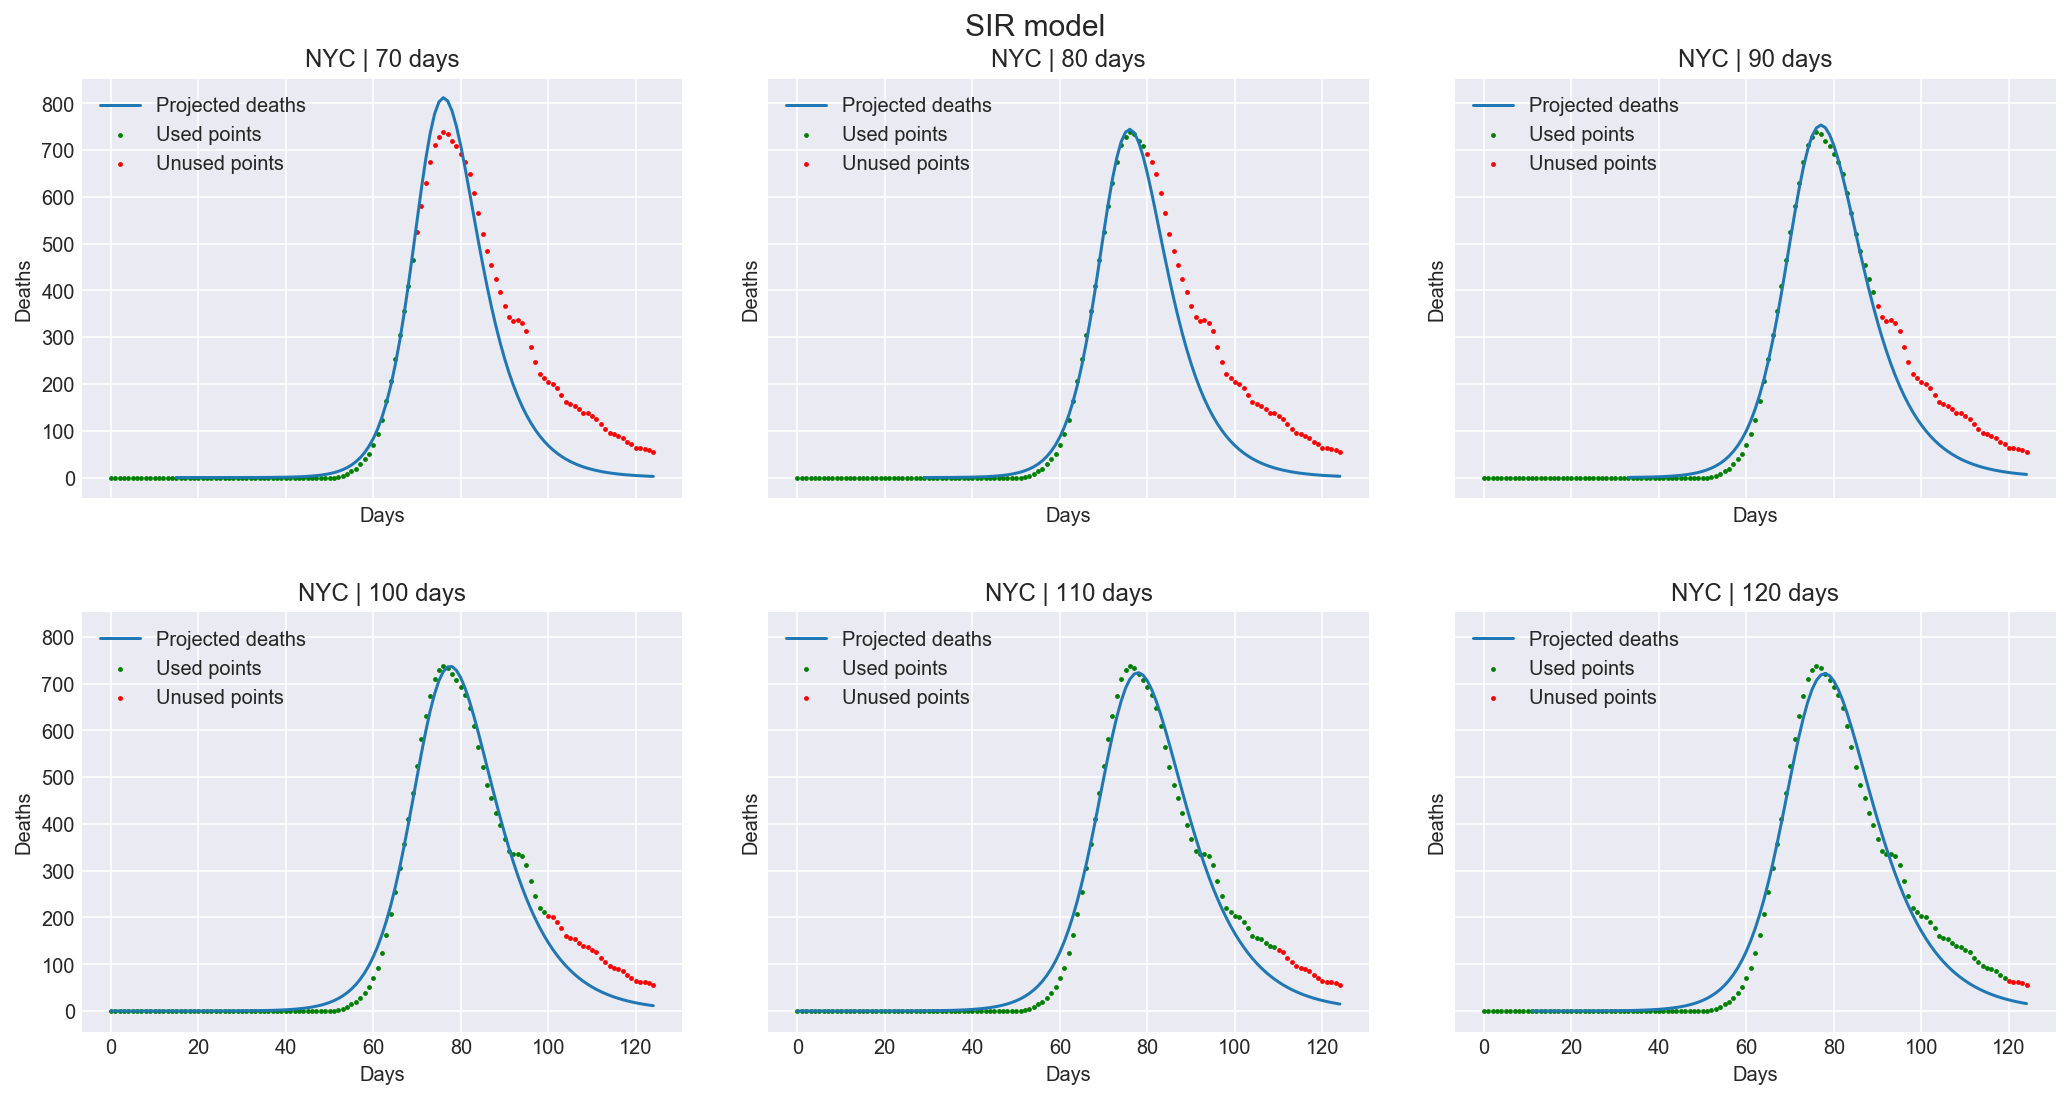

In [398]:
get_model_stats(simple_sir, rmse_loss, smooth_data_nyc, range(70, 130, 10), "SIR model", 
                param_cols=["offset", "pop", "I_init", "R", "mort", "T_inf"],
                bounds=[(0, 50), (1e6, 8.4e6), (0, 1e-3), (1, 2.6), (0, 5e-2), (6, 8)])

<h2>Social distancing in NYC</h2>

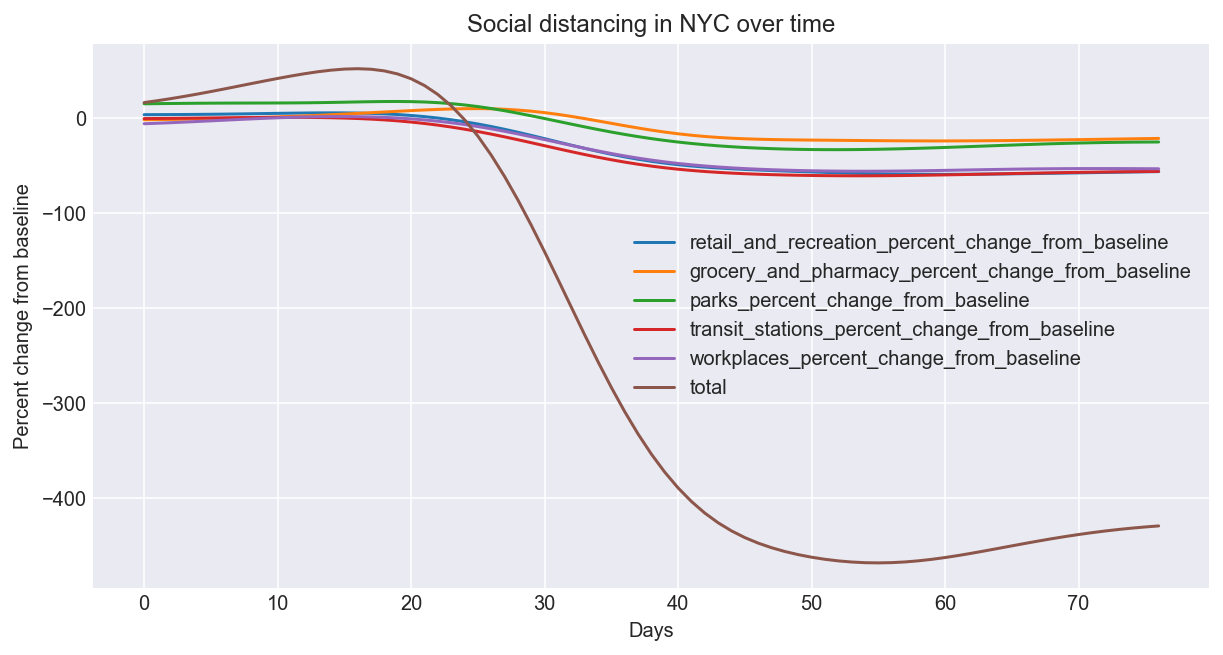

In [390]:
# Preprocess social distancing data from Google
start_date_sd = datetime.date(2020, 2, 15)
end_date_sd   = datetime.date(2020, 5, 1)
date_format_sd = "%Y-%m-%d"
smoothening_factor = 6

df_sd = pd.read_csv("Global_Mobility_Report.csv")
df_sd = df_sd[df_sd['country_region_code'] == 'US']

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

# Counties which NYC covers -- population data from Wikipedia
counties = {"New York County" : 1628706, 
            "Kings County"    : 2559903, 
            "Bronx County"    : 1418207, 
            "Queens County"   : 2253858}

total_pop = 0.
for c in counties.keys():
    total_pop += counties[c]

agg_sd_nyc = {}
for cat in categories:
    agg_sd_nyc[cat] = []

curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    
    val = {}
    
    for c in counties.keys():
        df_county = df_sd_curr[df_sd_curr["sub_region_2"] == c]
        
        for cat in categories:
            if cat in val:
                val[cat] += counties[c] * np.array(df_county[cat])[0]
            else:
                val[cat] = counties[c] * np.array(df_county[cat])[0]
                
    for cat in categories:
        val[cat] /= total_pop
        agg_sd_nyc[cat].append(val[cat])
    
    curr_date = curr_date + datetime.timedelta(days=1)
    
agg_sd_nyc["total"] = np.zeros(len(agg_sd_nyc[categories[0]]))

# Get the total
for cat in agg_sd_nyc.keys():
    agg_sd_nyc[cat] = np.array(agg_sd_nyc[cat])
    agg_sd_nyc["total"] += agg_sd_nyc[cat]

# Plot the array
plt.figure(figsize=(10,5))
for label in agg_sd_nyc.keys():
    agg_sd_nyc[label] = smoothen(agg_sd_nyc[label], smoothening_factor)
    plt.plot(agg_sd_nyc[label], label=label)

plt.title("Social distancing in NYC over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

We now use a time-dependent $R$ value 

$$R(t) = R_0 + \mu \cdot s$$

where $R_0, \mu$ are tunable parameters and $s$ is the social distancing metric written as the sum

$$
s = \Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w}
$$

where each of the terms on the RHS above denote percentage change from baseline in mobility at the following locations

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces

In [528]:
# Definition of the model
def R_sd(t, R_0, mu, sd_offset, sd_metric, offset):
    sd_offset = int(sd_offset)
    offset = int(offset)
    
    if t + sd_offset + offset >= sd_metric.shape[0]:
#         print(R_0 + mu * sd_metric[-1])
        return R_0 + mu * sd_metric[-1]
    else:
#         print(R_0 + mu * sd_metric[-1])
        return R_0 + mu * sd_metric[t + sd_offset + offset]

def R_sd_v2(t, R_max, delta_R, sd_offset, sd_metric, offset):    
    sd_offset = int(sd_offset)
    offset = int(offset)
    
    sd_max = np.max(sd_metric)
    sd_min = np.min(sd_metric)
    
    if t + sd_offset + offset >= sd_metric.shape[0]:
        sd = sd_metric[-1]
    else:
        sd = sd_metric[t + sd_offset + offset]
    
    return R_max - delta_R * (sd_max - sd) /  (sd_max - sd_min)
    
def sir_sd(t_max, offset, pop,  I_init, case_mortality, T_inf, R_0, mu, sd_offset):
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    I = I_init
    X = 0
    
    for t in range(1, t_max + 1):
        S, I, X = SIR_model(t, [S, I, X], R_sd_v2, case_mortality, T_inf, 1, R_0, mu, sd_offset, padded_sd, offset)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

Optimization terminated successfully.6.0e+00 2.7e+00 8.6e-01 2.0e+01] conv: 1.741e+00
Optimization terminated successfully.6.0e+00 2.7e+00 8.7e-01 1.9e+01] conv: 1.027e+00
Optimization terminated successfully.7.1e+00 2.7e+00 8.5e-01 2.0e+01] conv: 1.009e+00
Optimization terminated successfully.7.9e+00 2.7e+00 9.0e-01 2.0e+01] conv: 2.182e+00
Optimization terminated successfully.8.0e+00 2.7e+00 9.0e-01 2.0e+01] conv: 1.659e+00


,Breakpoint,Loss,offset,pop,I_init,mort,T_inf,R_max,delta_R,sd_offset
0,65.0,141.855185,40.341119,8.362111e+06,0.000515,0.001460,6.000000,2.700000,0.867303,19.708708
0,70.0,170.611415,46.525468,8.356309e+06,0.002642,0.001225,6.000000,2.700000,0.850000,19.185332
0,75.0,86.813525,49.361323,8.352011e+06,0.005886,0.001925,7.148663,2.700000,0.854669,19.835801
0,80.0,33.720755,49.030496,8.311831e+06,0.006533,0.002429,7.932163,2.700000,0.900000,19.988567
0,85.0,17.932815,40.955350,8.391125e+06,0.001265,0.002626,8.000000,2.666056,0.899821,19.749537


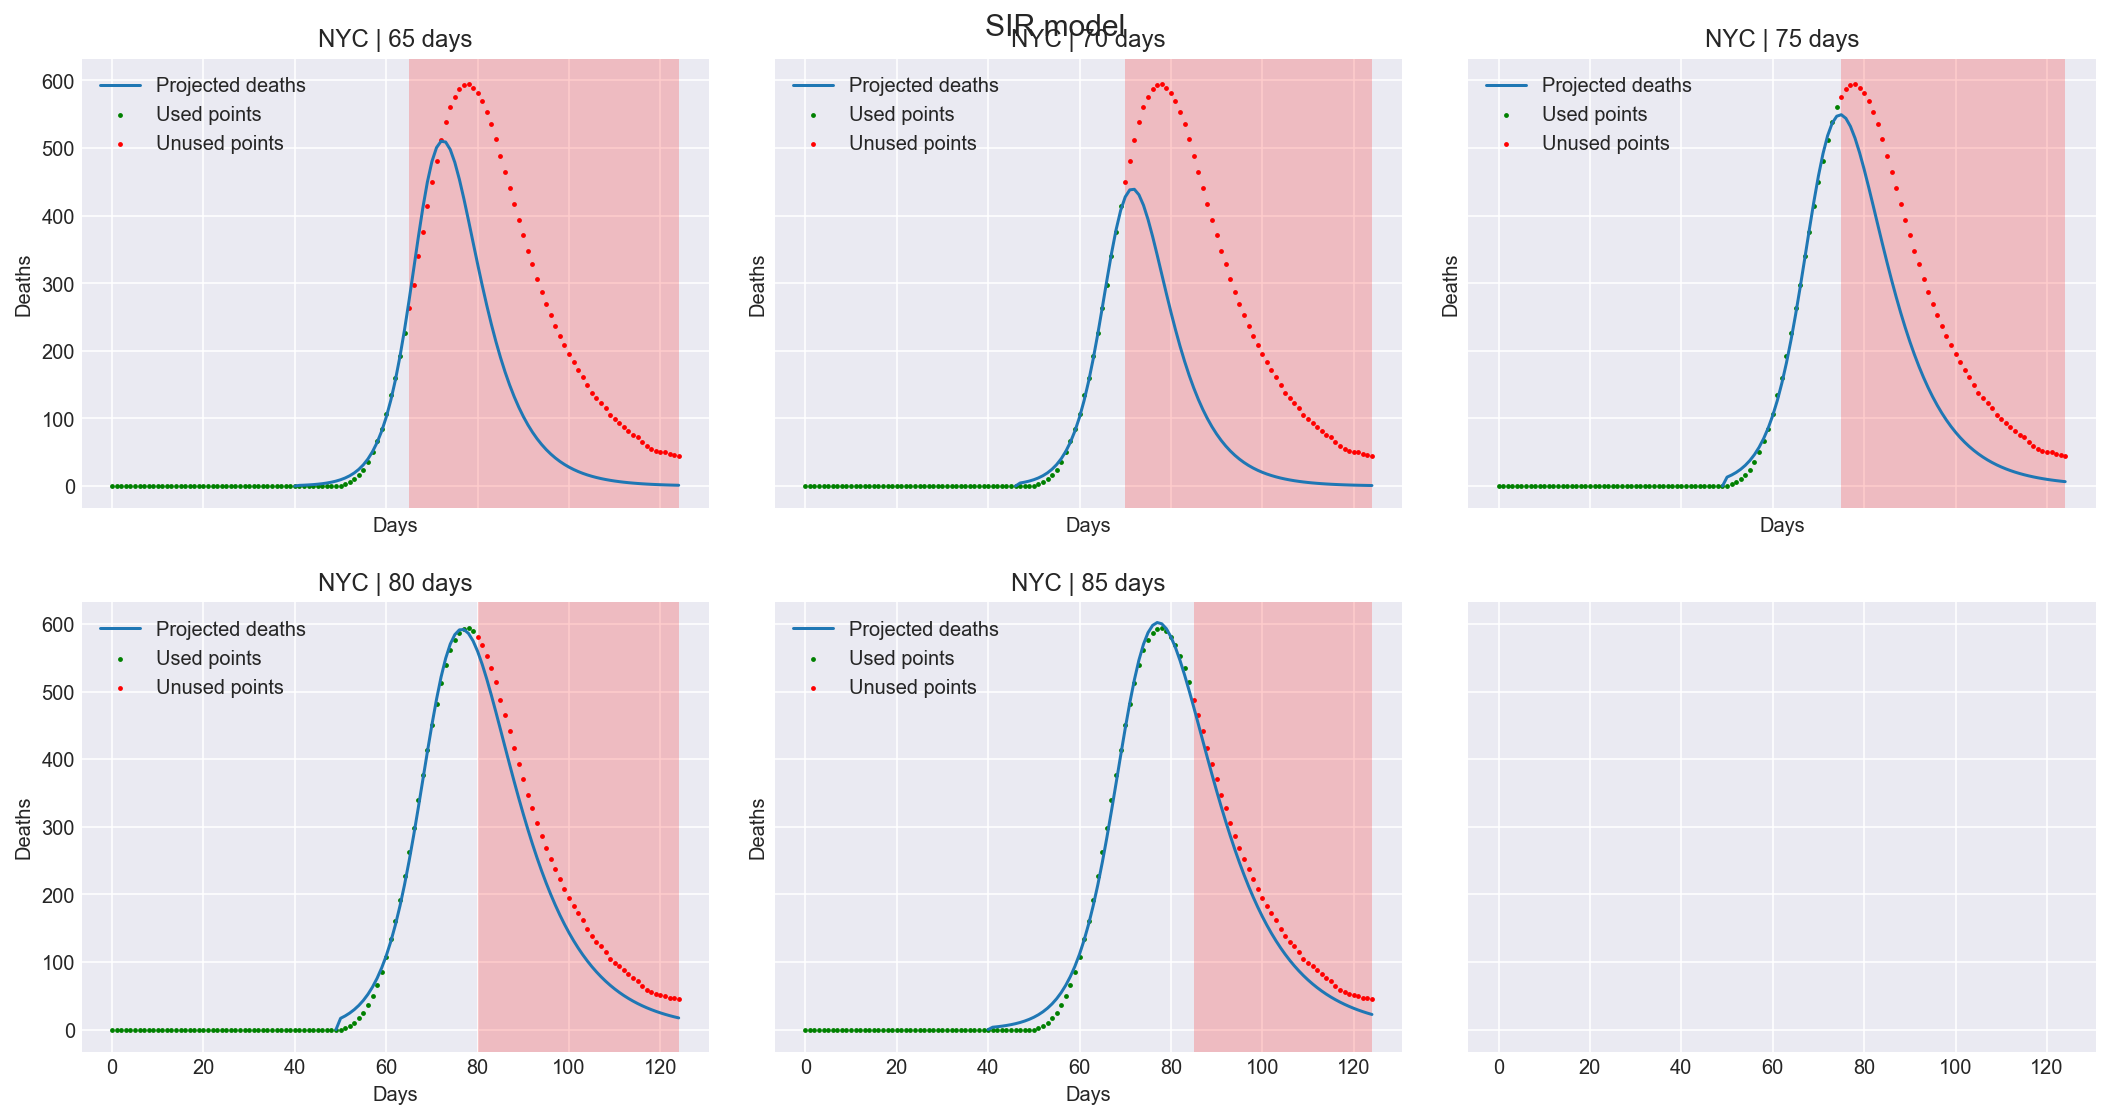

In [533]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_nyc["total"][0], agg_sd_nyc["total"])) 

get_model_stats(sir_sd, rmse_loss, smooth_data_nyc, list(range(65, 90, 5)), "SIR model", 
                param_cols=["offset", "pop", "I_init", "mort", "T_inf", "R_max", "delta_R", "sd_offset"],
                bounds=[(40, 50), (8.3e6, 8.4e6), (1e-6, 1e-2), (0, 5e-2), (6, 8), (1, 2.7), (0.85, 0.9), (10, 20)])

We see that the long-tail problem has been somewhat mitigated. However, the peak prediction is still bad because the model does not fit well to the initial part of the curve.

<h1>SIRD model with social distancing</h1>

$$
\frac{dS}{dt} = -\frac{RIS}{T_{inf}} 
$$ 


$$
\frac{dI}{dt} = \frac{RIS}{T_{inf}}   - (\gamma_R + \gamma_X)I
$$

$$
\frac{dX}{dt} = \gamma_XI
$$


In [670]:
def SIRD_fsm(t, y, R_t, T_inf, gamma_r, gamma_x, *R_args):
    if callable(R_t):
        R = R_t(t, *R_args)
    else:
        R = R_t
    
    S, I, X = y
#     print("R: {}".format(R))
    
    S_out = S - (R * I * S / T_inf)
    I_out = I + (R * I * S / T_inf) - (gamma_r + gamma_x) * I
    X_out = X + gamma_x * I

    return [S_out, I_out, X_out]

def sird_sd(t_max, offset, pop,  I_init, T_inf, gamma_r, gamma_x, R_0, mu, sd_offset):
#     print("offset: {}, pop: {}, I_init: {}, T_inf: {}, gamma_r: {}, gamma_x: {}, R_0: {}, mu: {}, sd_offset: {}"
#           .format(offset, pop, I_init, T_inf, gamma_r, gamma_x, R_0, mu, sd_offset)
#          )
    
    result = np.zeros(t_max + 1, dtype=float)
    result[0] = 0

    S = 1
    I = I_init
    X = 0

    for t in range(1, t_max + 1):
        S, I, X = SIRD_fsm(t, [S, I, X], R_sd_v2, T_inf, gamma_r, gamma_x, R_0, mu, sd_offset, padded_sd, offset)
        result[t] = X 
    
    result[1:] = np.diff(result)
    return result * pop

Optimization terminated successfully.6.0e+00 5.0e-02] conv: 1.673e+00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.6.0e+00 5.0e-02] conv: 1.096e+00
Optimization terminated successfully.6.0e+00 6.0e-02] conv: 1.087e+00
Optimization terminated successfully.6.0e+00 5.0e-02] conv: 1.051e+00
Optimization terminated successfully.6.0e+00 5.5e-02] conv: 1.009e+00
Optimization terminated successfully.6.2e+00 6.0e-02] conv: 1.013e+00
Optimization terminated successfully.6.1e+00 6.0e-02] conv: 1.300e+00
Optimization terminated successfully.6.1e+00 6.0e-02] conv: 1.140e+00
Optimization terminated successfully.6.0e+00 6.0e-02] conv: 1.083e+00


,Breakpoint,Loss,offset,pop,I_init,X_init,T_inf,gamma_r,gamma_x,R_max,delta_R,sd_offset
0,60.0,85.071818,40.860412,8.110713e+06,0.000100,0.0,6.001962,0.050000,0.000166,2.500000,0.973687,20.286831
0,65.0,100.098810,40.176308,8.392894e+06,0.000126,0.0,6.000000,0.050000,0.000170,2.500000,0.950001,20.865978
0,70.0,32.206045,40.177431,8.002679e+06,0.000185,0.0,6.007252,0.059965,0.000150,2.494378,1.047135,22.815542
0,75.0,66.766100,40.495331,8.080616e+06,0.000221,0.0,6.002392,0.050000,0.000159,2.336528,1.049416,22.063676
0,80.0,58.007681,44.830337,8.140285e+06,0.000681,0.0,6.004196,0.054770,0.000167,2.347351,1.046301,22.187331
0,85.0,33.429589,41.123670,8.062406e+06,0.000270,0.0,6.246115,0.059932,0.000169,2.489898,0.952825,22.289426
0,90.0,22.026820,40.350064,8.242644e+06,0.000177,0.0,6.052986,0.060000,0.000158,2.458286,0.953053,20.364611
0,95.0,19.684764,40.735548,8.136764e+06,0.000153,0.0,6.031523,0.060000,0.000158,2.500000,0.951209,20.155325
0,120.0,19.370454,44.432795,8.167363e+06,0.000500,0.0,6.000000,0.060000,0.000155,2.500000,0.950000,20.631501


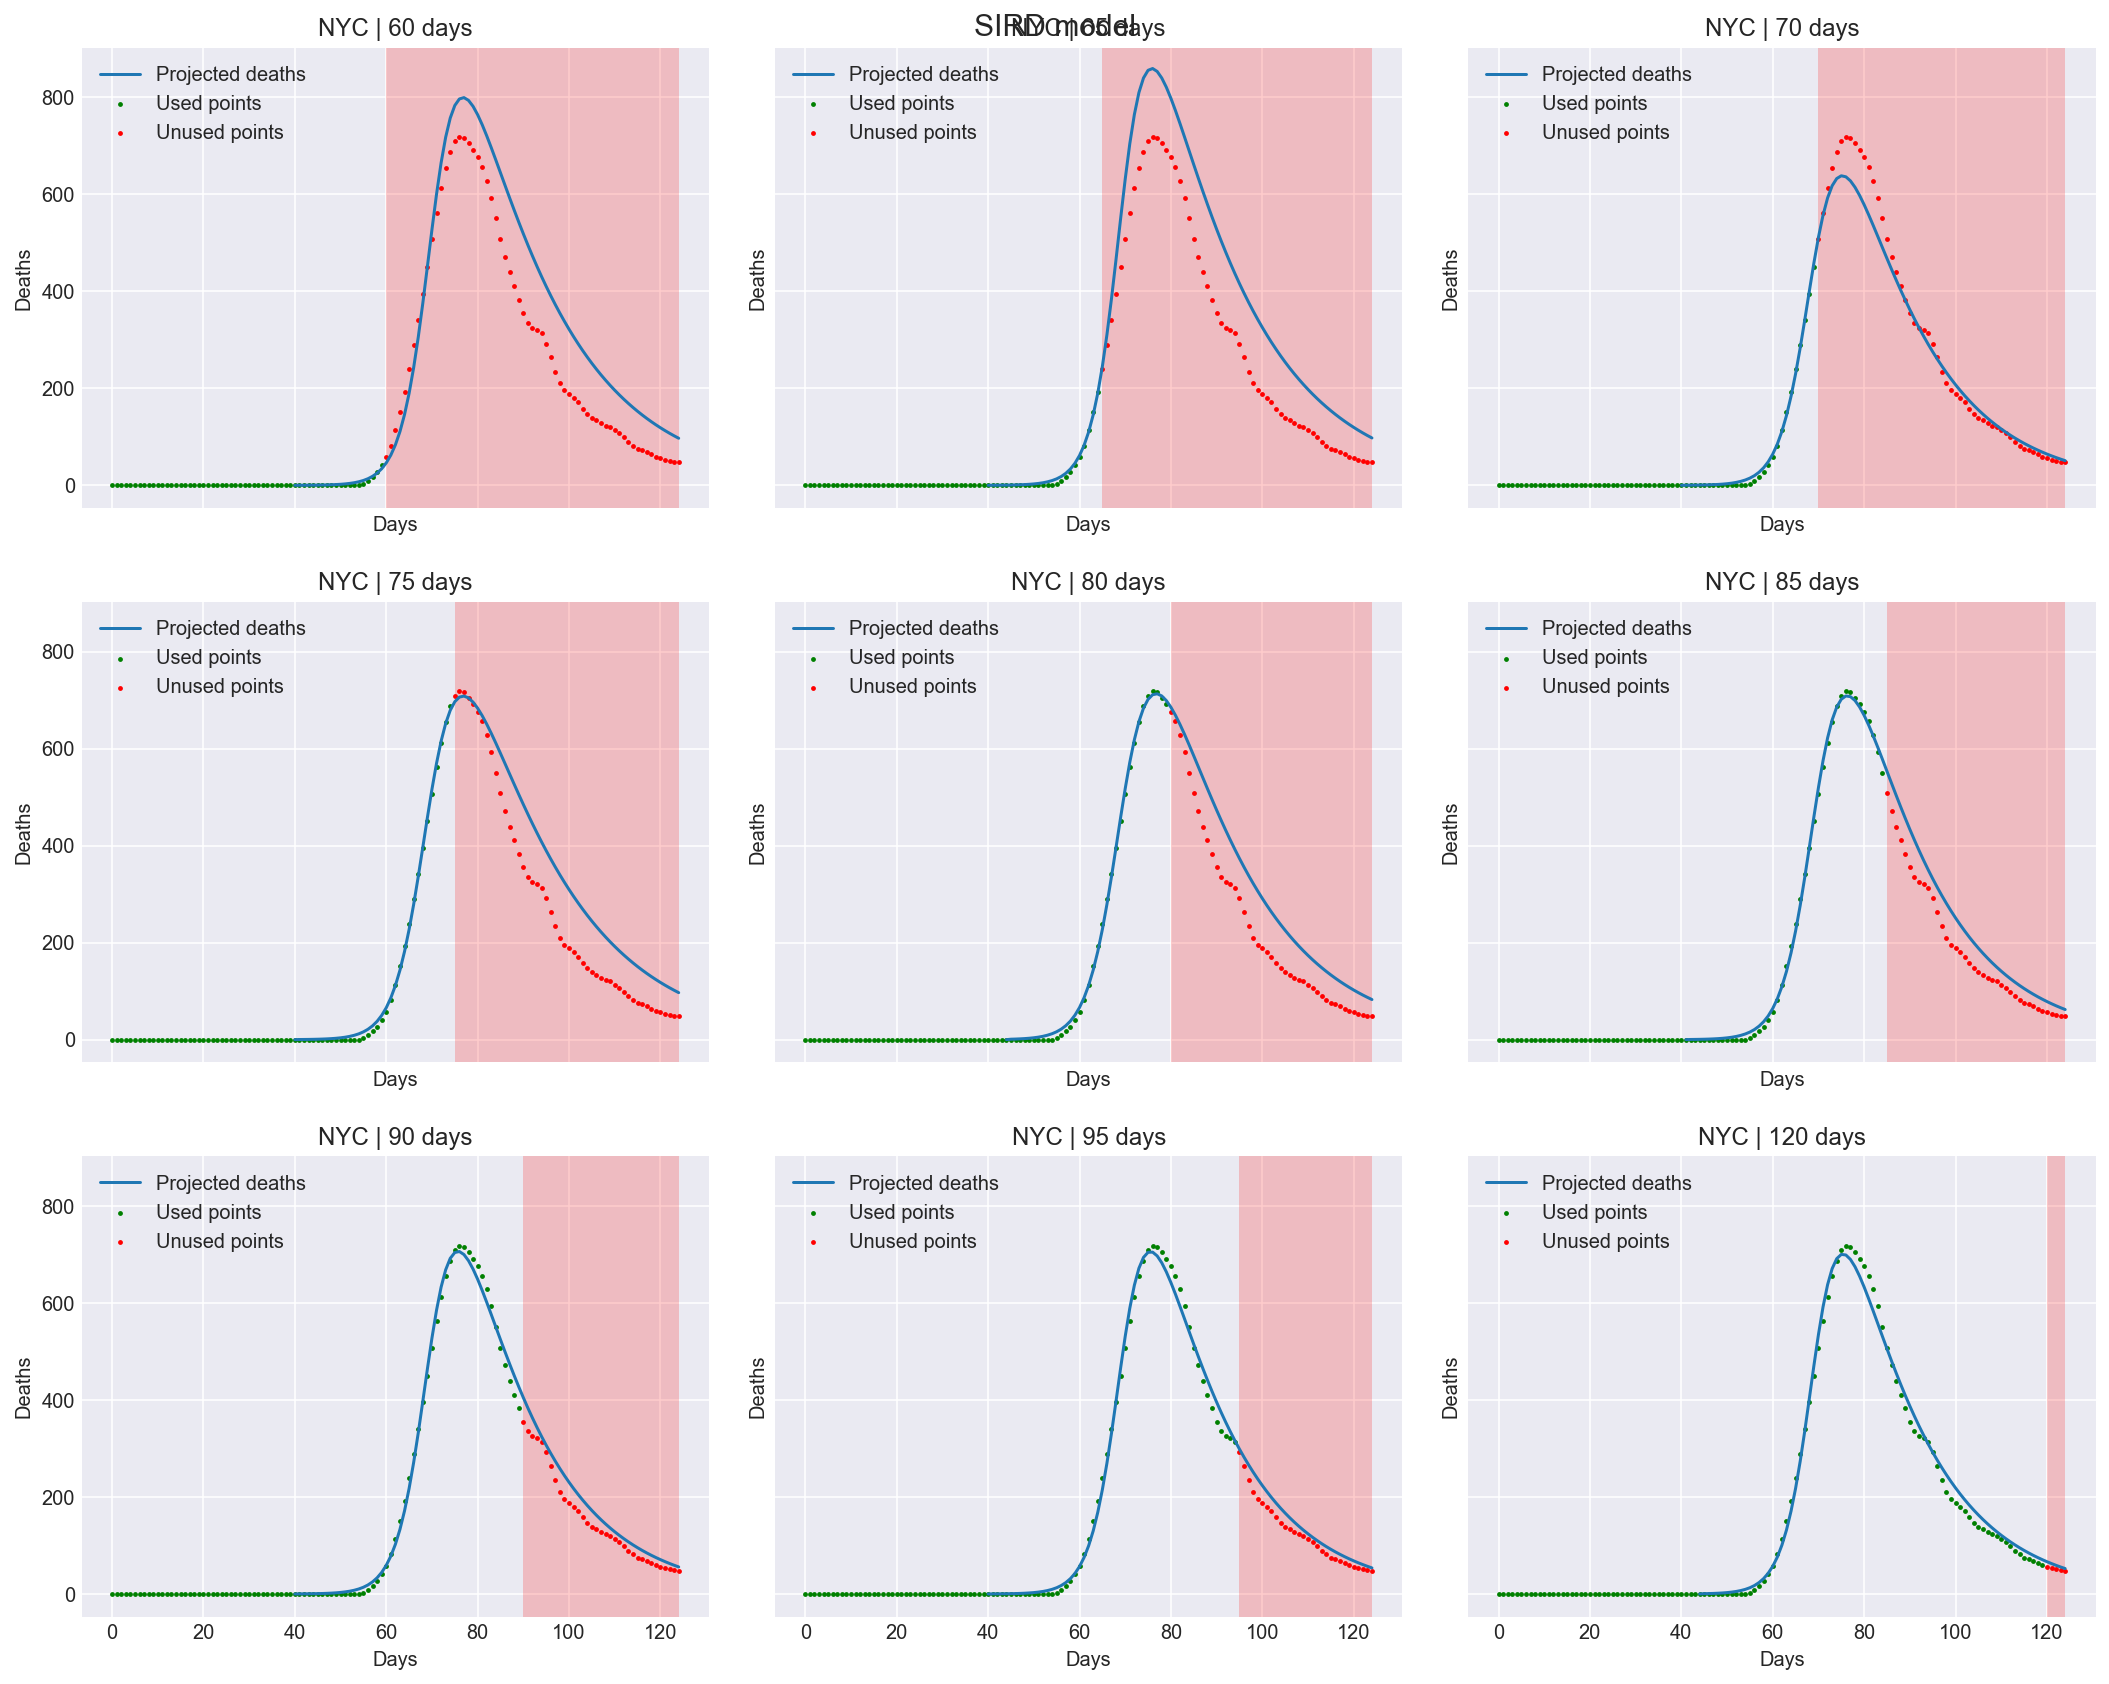

In [640]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_nyc["total"][0], agg_sd_nyc["total"])) 

get_model_stats(sird_sd, rmse_loss, smooth_data_nyc, list(range(60, 100, 5)) + [120], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_r", "gamma_x", "R_max", "delta_R", "sd_offset"],
                bounds=[(40, 45), (8e6, 8.4e6), (1e-4, 1e-2), (6, 8), (5e-2, 6e-2), (1.5e-4, 1.7e-4), (1.4, 2.5), (0.95, 1.05), (20, 23)])

<h2>Wuhan, China</h2>

In [565]:
# Fetch global data
! rm time_series_covid19_deaths_global.csv
! wget -nv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

2020-05-28 18:09:22 URL:https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv [88480/88480] -> "time_series_covid19_deaths_global.csv" [1]


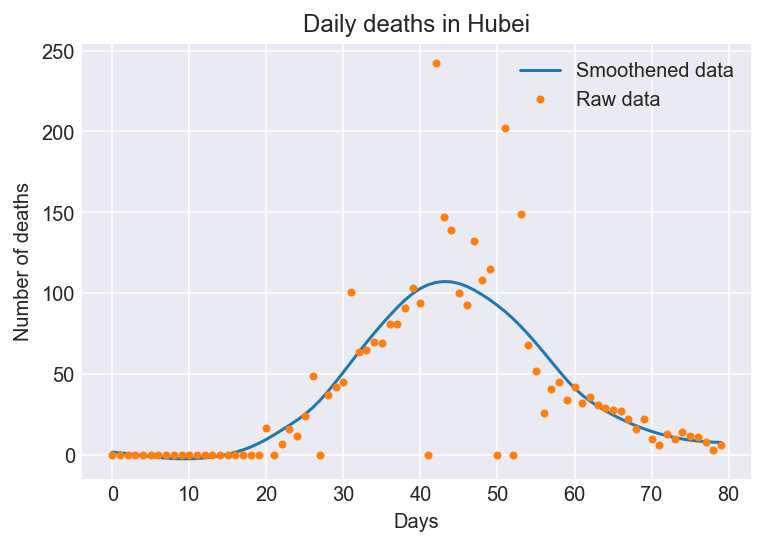

In [681]:
df_global = pd.read_csv("time_series_covid19_deaths_global.csv")
df_hubei = df_global[df_global["Province/State"] == "Hubei"]
date_format = "%-m/%-d/%y"
start_date_global = datetime.date(2020, 1, 22)
end_date_global = datetime.date(2020, 5, 27)

data_hubei = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_hubei.append(df_hubei[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)
    
data_hubei[1:] = np.diff(data_hubei)
data_hubei = data_hubei[:60]
smooth_data_hubei = np.concatenate((np.zeros(20), data_hubei))
smooth_data_hubei = smoothen(savgol_filter(smooth_data_hubei, 37, 3), 2)

plt.plot(smooth_data_hubei, label="Smoothened data")
plt.plot(np.concatenate((np.zeros(20), data_hubei)), '.', label="Raw data")
plt.title("Daily deaths in Hubei")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.
Optimization terminated successfully.5.0e-02 1.9e-04] conv: 1.061e+00
Optimization terminated successfully.5.0e-02 1.9e-04] conv: 1.159e+00


,Breakpoint,Loss,offset,pop,I_init,T_inf,gamma_r,gamma_x,R_max,delta_R,sd_offset
0,40.0,17.728222,1.0,11100000.0,0.000006,5.701594,0.050051,0.000190,2.4,2.3,20.480482
0,50.0,15.244303,1.0,11100000.0,0.000002,5.003933,0.050000,0.000190,2.4,2.3,20.783094
0,60.0,15.483351,1.0,11100000.0,0.000002,5.004497,0.050003,0.000187,2.4,2.3,20.316262


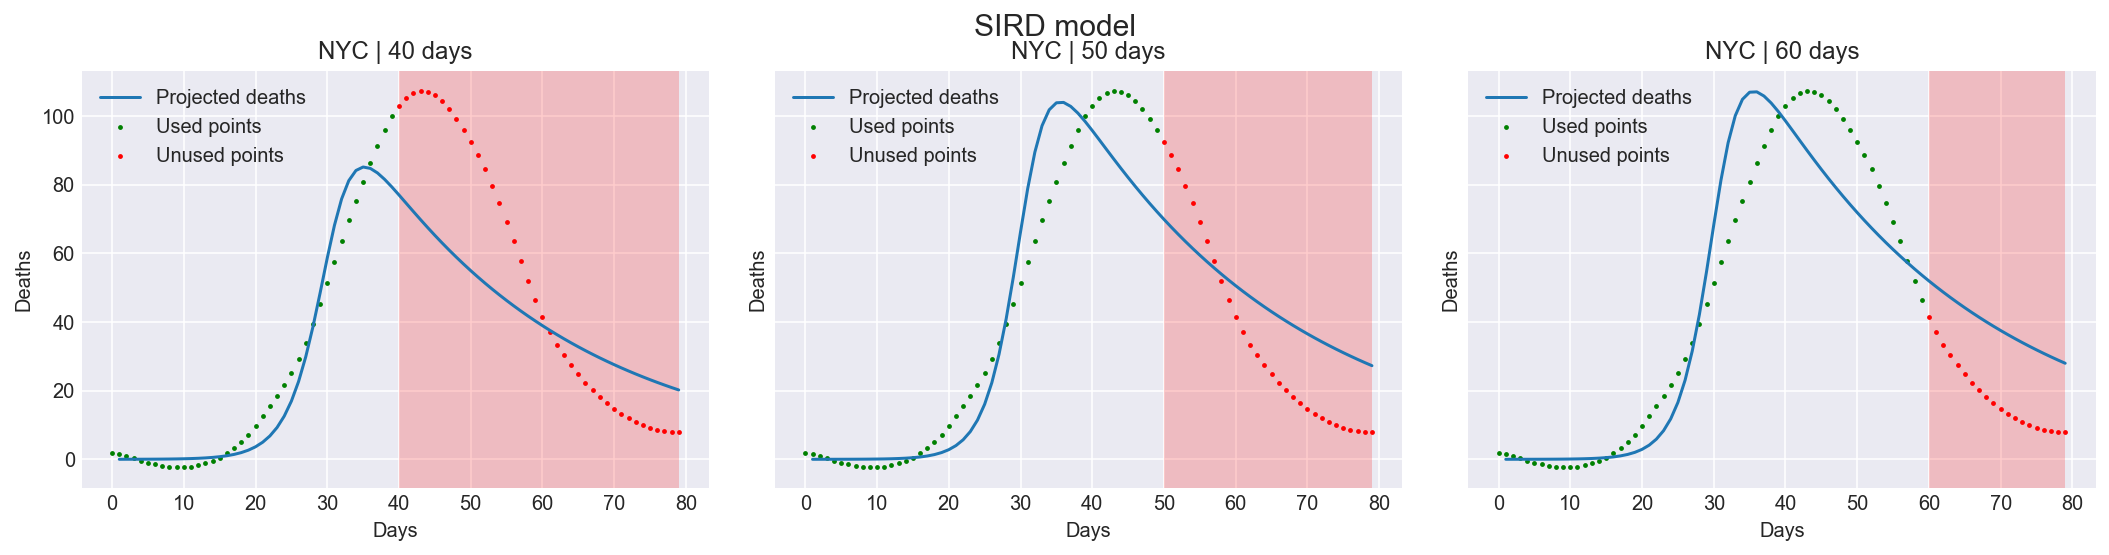

In [689]:
# Since mobility data is not available we construct our own
padded_sd = -500 * expit(np.arange(-50, 60, 1) / 2)
get_model_stats(sird_sd, rmse_loss, smooth_data_hubei, [40, 50, 60], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_r", "gamma_x", "R_max", "delta_R", "sd_offset"],
                bounds=[(1, 1), (1.11e7, 1.11e7), (1e-7, 1e-4), (5, 8), (5e-2, 6e-2), (1.0e-4, 1.9e-4), (2.4, 2.4), (2.3, 2.3), (20, 23)])

Conclusion: Lockdown strategies which decrease $R$ significantly lead to a decrease in the number of deaths. However, as long as infections remain, re-opening is risky. Further, the $R$ pre-lockdown controls the rate of rise of disease upto the peak and $R$ post lockdown controls how fast we come down from the peak

<h2>Italy</h2>

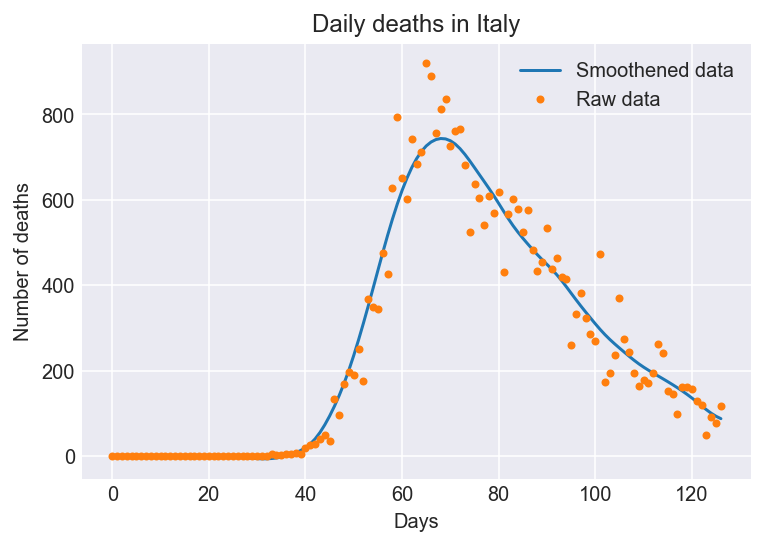

In [699]:
# Get the death data
df_italy = df_global[df_global["Country/Region"] == "Italy"]

data_italy = []
curr_date = deepcopy(start_date_global)
while curr_date <= end_date_global:
    data_italy.append(df_italy[curr_date.strftime(date_format)].iloc[0])
    curr_date = curr_date + datetime.timedelta(days=1)
    
data_italy[1:] = np.diff(data_italy)
smooth_data_italy = smoothen(savgol_filter(data_italy, 37, 3), 2)

plt.plot(smooth_data_italy, label="Smoothened data")
plt.plot(data_italy, '.', label="Raw data")
plt.title("Daily deaths in Italy")
plt.xlabel("Days")
plt.ylabel("Number of deaths")
plt.legend()
plt.show()

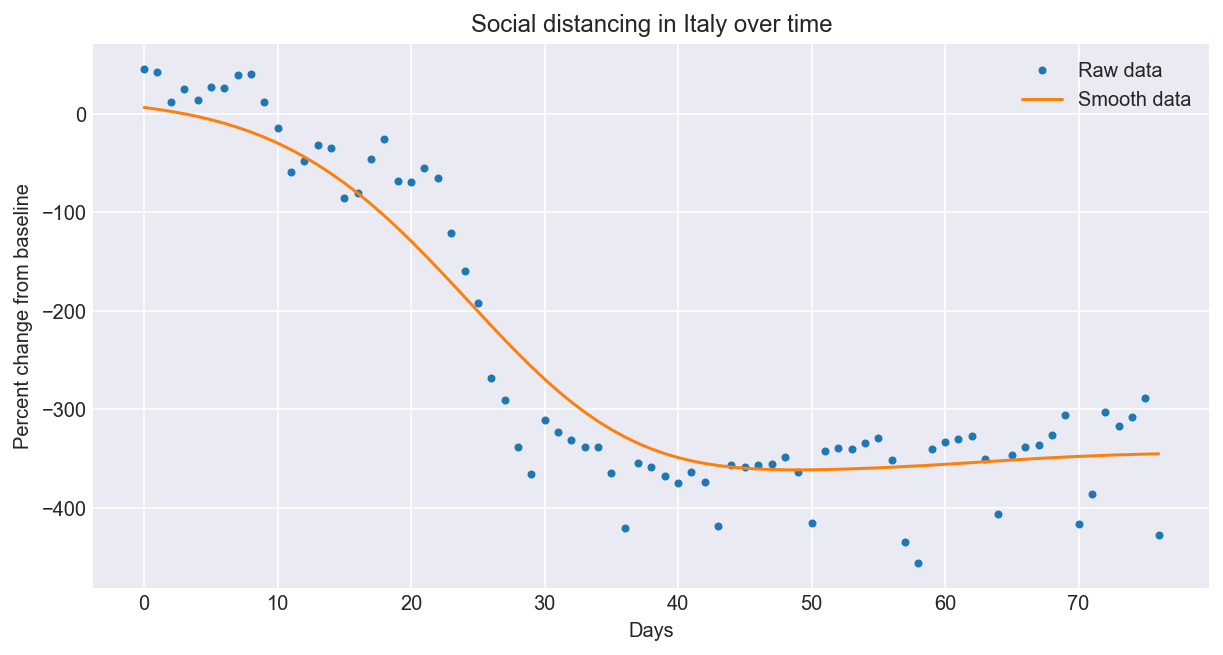

In [709]:
# Preprocess social distancing data
df_sd = pd.read_csv("Global_Mobility_Report.csv")
df_sd = df_sd[df_sd['country_region_code'] == 'IT']
df_sd = df_sd[pd.isnull(df_sd['sub_region_1'])]

categories = ["retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline"]

agg_sd_italy = []
curr_date = deepcopy(start_date_sd)

while curr_date <= end_date_sd:
    df_sd_curr = df_sd[df_sd["date"] == curr_date.strftime(date_format_sd)]
    val = 0
    
    for cat in categories:
        val += np.array(df_sd_curr[cat])[0]
        
    agg_sd_italy.append(val)
    curr_date = curr_date + datetime.timedelta(days=1)
    
# Plot the array
agg_sd_italy = np.array(agg_sd_italy)
plt.figure(figsize=(10,5))
plt.plot(agg_sd_italy, '.', label="Raw data")
agg_sd_italy = smoothen(smoothen(agg_sd_italy, 6), 6)
plt.plot(agg_sd_italy, label="Smooth data")
plt.title("Social distancing in Italy over time")
plt.xlabel("Days")
plt.ylabel("Percent change from baseline")
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Optimization terminated successfully.
Optimization terminated successfully.5.2e-02 1.7e-04] conv: 1.088e+00
Optimization terminated successfully.5.0e-02 1.7e-04] conv: 1.191e+00
Optimization terminated successfully.5.9e-02 1.7e-04] conv: 1.017e+00
Optimization terminated successfully.5.9e-02 1.7e-04] conv: 1.283e+00
Optimization terminated successfully.6.0e-02 1.7e-04] conv: 1.170e+00
Optimization terminated successfully.6.0e-02 1.7e-04] conv: 1.082e+00
Optimization terminated successfully.5.0e-02 1.7e-04] conv: 1.009e+00
Optimization terminated successfully.5.0e-02 1.7e-04] conv: 1.020e+00


,Breakpoint,Loss,offset,pop,I_init,T_inf,gamma_r,gamma_x,R_max,delta_R,sd_offset
0,40.0,161.566209,20.654418,10000000.0,0.000100,7.514280,0.052142,0.000165,2.032951,0.958994,22.228461
0,43.0,155.860108,23.163459,10000000.0,0.000100,6.042102,0.052355,0.000165,2.443099,0.961813,20.287615
0,46.0,171.616269,24.455493,10000000.0,0.000115,6.000000,0.050000,0.000170,2.500000,0.983092,20.755229
0,49.0,139.529251,21.444822,10000000.0,0.000100,6.000072,0.059279,0.000165,2.259795,1.040564,22.036793
0,52.0,107.586412,20.779357,10000000.0,0.000175,6.004722,0.058939,0.000165,1.990616,1.045257,22.413987
0,55.0,105.794715,20.535809,10000000.0,0.000286,6.006849,0.060000,0.000165,1.858480,1.049880,22.180375
0,58.0,105.845862,20.105211,10000000.0,0.000368,6.006489,0.059772,0.000165,1.791963,1.049485,22.938089
0,100.0,29.698125,20.013747,10000000.0,0.000474,7.985907,0.050000,0.000170,2.145448,0.950817,22.582636
0,120.0,29.356176,20.929439,10000000.0,0.000468,7.923779,0.050000,0.000170,2.122294,0.950000,22.772917


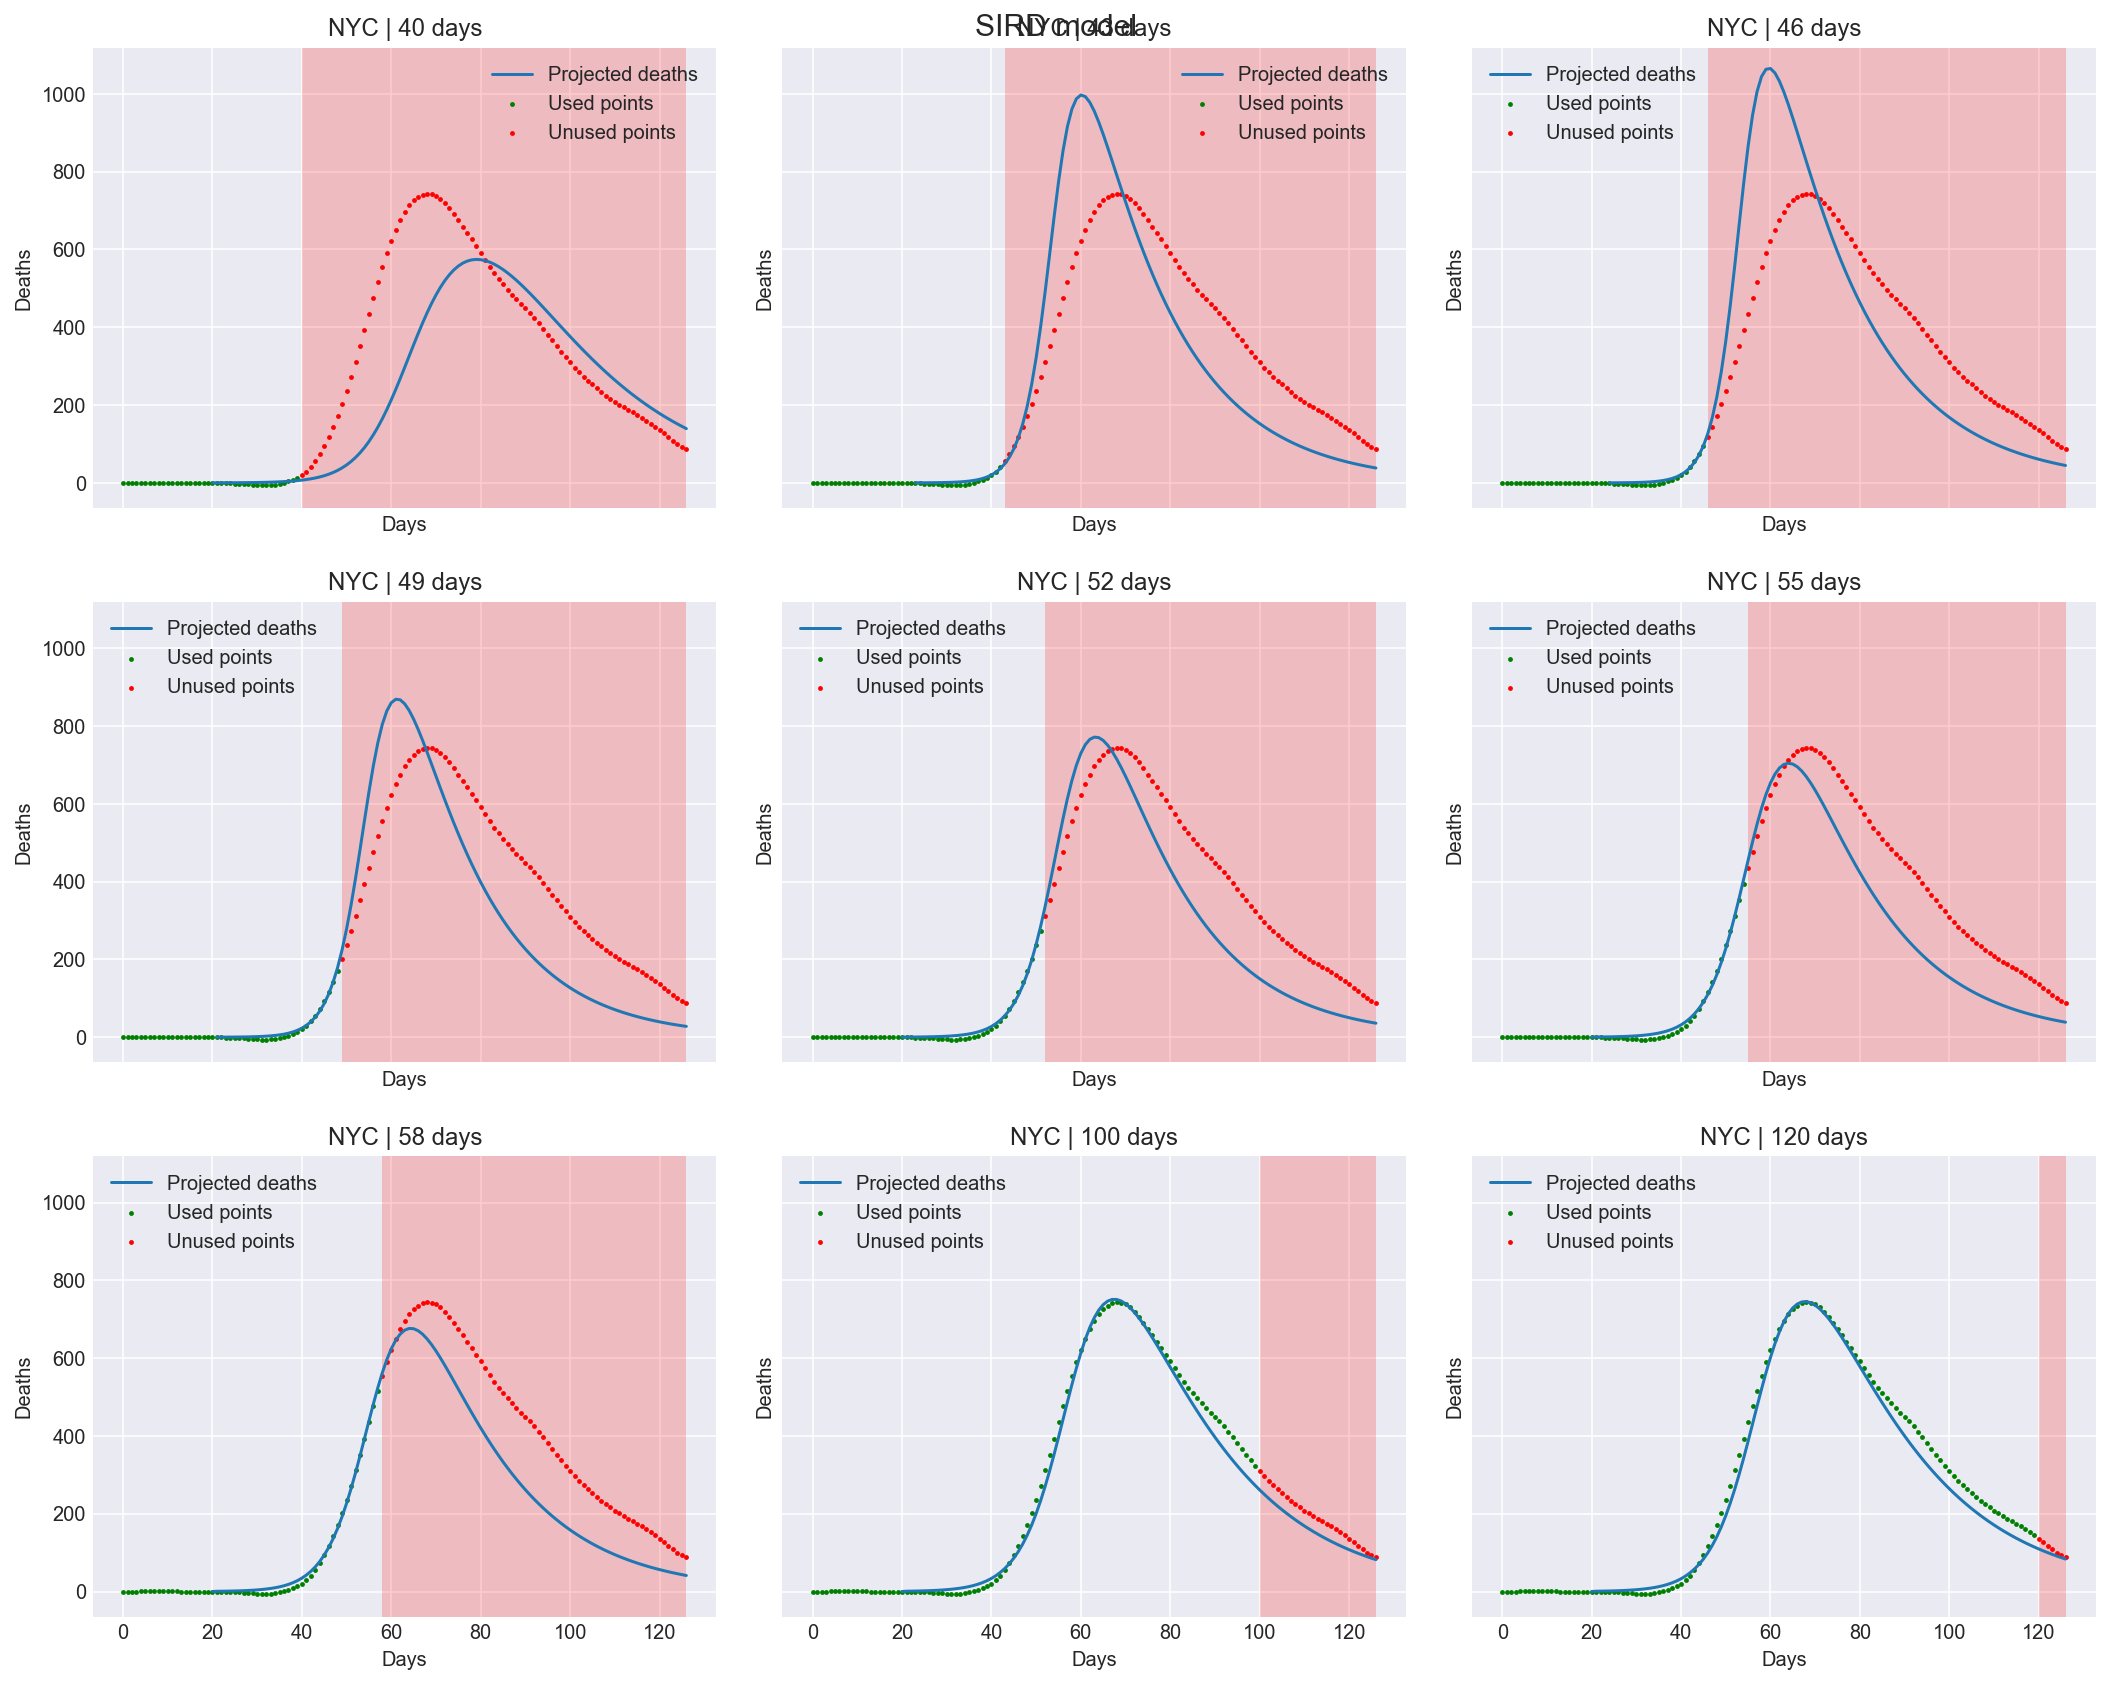

In [720]:
# Get model stats
pad_sd = 60 # How many days to pad the social distancing data by 
padded_sd = np.concatenate((np.ones(pad_sd) * agg_sd_italy[0], agg_sd_italy)) 

get_model_stats(sird_sd, rmse_loss, smooth_data_italy, list(range(40, 60, 3)) + [100, 120], "SIRD model", 
                param_cols=["offset", "pop", "I_init", "T_inf", "gamma_r", "gamma_x", "R_max", "delta_R", "sd_offset"],
                bounds=[(20, 39), (1e7, 1e7), (1e-4, 5e-4), (6, 8), (5e-2, 6e-2), (1.65e-4, 1.7e-4), (1.6, 2.5), (0.95, 1.05), (20, 23)])